## Outline

* Importing the required libraries;
* Proceseed data loading and preparation;
* Model definition, training;
* Evaluation.

----------

### Importing the required libraries.

We'll try to solve this problem using a neural network constructed using PyTorch `nn.Module` class. All the required tools will be imported.

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

Check cuda compatibility for gpu usage.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current device : {device}")

Current device : cuda


-----

### Loading processed data.

In [3]:
train_df = pd.read_csv("train_processed.csv")
test_df = pd.read_csv("test_processed.csv")

In [4]:
train_df.head()

,class,cap-diameter,cap-shape,cap-color,does-bruise-or-bleed,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,1,0.800897,0.488037,0.460691,0.444231,0.571559,-0.680920,0.523308,0.582287,0.466735,0.460745,0.471157,0.428394
1,0,-0.227703,0.489837,0.282747,0.444231,0.285108,-0.577200,-0.577318,0.403348,0.408902,0.003842,0.471157,0.653996
2,1,0.424930,0.488037,0.873944,0.444231,0.571559,0.185883,-0.151150,0.389062,0.466735,0.460745,0.605072,0.653996
3,1,-0.444599,0.488037,0.588087,0.444231,0.518990,-0.810570,-0.571142,0.582287,0.466735,0.460745,0.471157,0.417541
4,1,0.161152,0.489837,0.502929,0.444231,0.571559,-1.103208,-0.345087,0.582287,0.466735,0.460745,0.325389,0.428394


Creating data arrays.

In [5]:
X_train = train_df.iloc[:, 1:].values
y_train = train_df["class"].values
X_test = test_df.values

This is a random state argument to reprodruce results.

In [6]:
rs = 117

A validation dataset should be created for evaluation.

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.30, 
                                                  random_state = rs, stratify = y_train)

With data arrays being creatd, they should be converted to tensors for PyTorch usage. Then we create the tensor datasets and data loader that will be passed to the model.

In [1]:
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train).unsqueeze(1).double()

X_val_tensor = torch.from_numpy(X_val)
y_val_tensor = torch.from_numpy(y_val).unsqueeze(1).double()

X_test_tensor = torch.from_numpy(X_test)

NameError: name 'torch' is not defined

In [9]:
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor)

In [10]:
train_dl = DataLoader(train_ds, batch_size = 128, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = 128, shuffle = False)

------------

### Model definition and training

We'll construct our model using the `nn.Module` class.
The network architecture will be as follow:

In [11]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.a1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.a2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_size2, output_size)
        self.a2 = nn.Sigmoid()

    def forward(self, x):
        x = self.a1(self.layer1(x))
        x = self.a2(self.layer2(x))
        x = self.a2(self.layer3(x))
        return x

In [12]:
input_dim = X_train_tensor.shape[1]
output_dim = 1
hidden_size1 = 12
hidden_size2 = 12

In [13]:
model = Model(input_size = input_dim, output_size = output_dim,
               hidden_size1 = hidden_size1, hidden_size2 = hidden_size2).double()
model.to(device)

Model(
  (layer1): Linear(in_features=12, out_features=12, bias=True)
  (a1): ReLU()
  (layer2): Linear(in_features=12, out_features=12, bias=True)
  (a2): Sigmoid()
  (layer3): Linear(in_features=12, out_features=1, bias=True)
)

These are the loss function to evaluate the model's performance and the optimizer to update the model's parameters.

In [14]:
criterion = nn.BCELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)

This is the training loop used to train and evaluate the model at the same time.

The training is done on 50 epochs, we use early stopping to keep track of the best models and avoid overfitting.

The history of losses and accuracies is saved in a dictionary.

In [15]:
epochs = 50
best_val_loss = float("inf")
counter = 0
patience = 5
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for inputs, targets in train_dl:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        predictions = (outputs > 0.5).double()
        correct_train += (predictions == targets).sum().item()
        total_train += targets.size(0)

    avg_train_loss = train_loss / len(train_dl)
    train_acc = correct_train / total_train
    history["train_loss"].append(avg_train_loss)
    history["train_acc"].append(train_acc)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_dl:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            predictions = (outputs > 0.5).double()
            correct_val += (predictions == targets).sum().item()
            total_val += targets.size(0)

    avg_val_loss = val_loss / len(val_dl)
    val_acc = correct_val / total_val
    history["val_loss"].append(avg_val_loss)
    history["val_acc"].append(val_acc)
    print(f"Epoch {epoch+1} / {epochs}, Train Loss:{avg_train_loss:.4f}, Val Loss:{avg_val_loss:.4f}\n" 
                                        f"\t\tTrain Acc:{train_acc:.4f}, Val Acc:{val_acc:.4f}")
    print()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, "final_model01.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

Epoch 1 / 50, Train Loss:0.4860, Val Loss:0.4530
		Train Acc:0.7768, Val Acc:0.7987

Epoch 2 / 50, Train Loss:0.4239, Val Loss:0.3923
		Train Acc:0.8113, Val Acc:0.8287

Epoch 3 / 50, Train Loss:0.3729, Val Loss:0.3594
		Train Acc:0.8377, Val Acc:0.8465

Epoch 4 / 50, Train Loss:0.3456, Val Loss:0.3347
		Train Acc:0.8525, Val Acc:0.8554

Epoch 5 / 50, Train Loss:0.3219, Val Loss:0.3144
		Train Acc:0.8651, Val Acc:0.8714

Epoch 6 / 50, Train Loss:0.3079, Val Loss:0.3024
		Train Acc:0.8739, Val Acc:0.8772

Epoch 7 / 50, Train Loss:0.2984, Val Loss:0.2939
		Train Acc:0.8794, Val Acc:0.8828

Epoch 8 / 50, Train Loss:0.2910, Val Loss:0.2906
		Train Acc:0.8836, Val Acc:0.8825

Epoch 9 / 50, Train Loss:0.2848, Val Loss:0.2828
		Train Acc:0.8869, Val Acc:0.8893

Epoch 10 / 50, Train Loss:0.2793, Val Loss:0.2778
		Train Acc:0.8894, Val Acc:0.8896

Epoch 11 / 50, Train Loss:0.2746, Val Loss:0.2726
		Train Acc:0.8915, Val Acc:0.8929

Epoch 12 / 50, Train Loss:0.2706, Val Loss:0.2690
		Train Acc:0

---------

### Evaluation

After the training is done, we'll evaluate the model's performance by plotting the accuracies and losses saved in the history.

In [2]:
history = torch.load("training_history.pth02")

In [3]:
import matplotlib.pyplot as plt

In [6]:
epochs = 50

- Loss

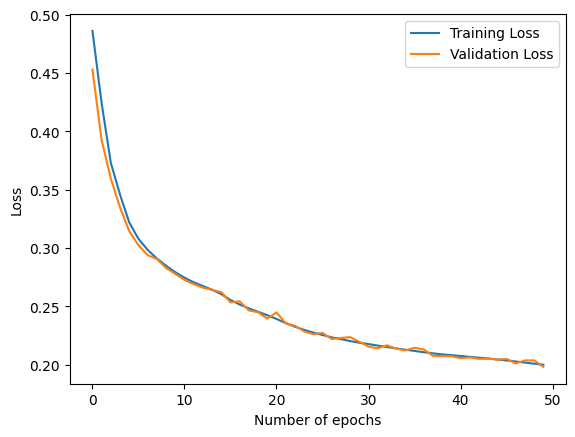

In [9]:
plt.plot(range(epochs), history["train_loss"])
plt.plot(range(epochs), history["val_loss"])
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.show()

* Accuracy

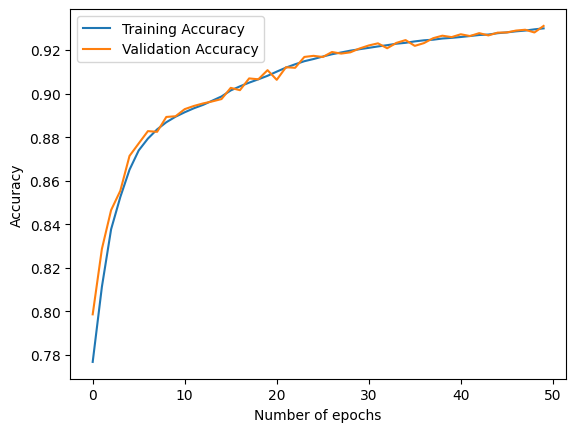

In [10]:
plt.plot(range(epochs), history["train_acc"])
plt.plot(range(epochs), history["val_acc"])
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.show()

----------

### Make predictions on the test set